# Quantum Machine Learning: Learning through examples


In [9]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Overview
1. Simple VQE example
2. VQE for LiH
3. VQA introduction
4. VQA applications - QAOA
5. VQA limitations - NISQ
6. Hybrid algorithms

# VQE
VQE are used for calculating the smallest eigenvalue of a given Hamiltonian. Hamiltonians are energy operators and represent energy evolution in a physical system. Thus, the least eigenvalue of a Hamiltonian corresponds to the energy of the least energy state, or the ground state.

# Simple VQE example
Hamiltonians are Hermitian operators. So in the first example we discuss, we will hand-create a Hermitian matrix instead of simulating a physical system. 
## Step 1: Obtaining the operator

In [2]:
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import OperatorBase
from qiskit.aqua.operators.primitive_ops import PrimitiveOp
from qiskit.opflow import CX,X
import numpy as np

op=QuantumCircuit(2)
op.x(0)
op.x(1)

print(op)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘


We can manually verify that the lowest eigenvalue of this matrix is -1. It is obtained when the system is in the following state:
\begin{equation*}
\frac{\left(\left|0\right\rangle - \left|1\right\rangle\right)}{\sqrt{2}}\frac{\left(\left|0\right\rangle + \left|1\right\rangle\right)}{\sqrt{2}}
\end{equation*}

## Step 2: Defining the ansatz

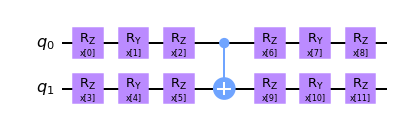

In [5]:
from qiskit.circuit import Parameter, QuantumCircuit, ParameterVector
ansatz=QuantumCircuit(2)
parameters=ParameterVector('x',length=2*6)

param_no=0
for i in range(2):
    ansatz.rz(parameters[param_no],i)
    param_no+=1
    ansatz.ry(parameters[param_no],i)
    param_no+=1
    ansatz.rz(parameters[param_no],i)
    param_no+=1
ansatz.cx(0,1)
for i in range(2):
    ansatz.rz(parameters[param_no],i)
    param_no+=1
    ansatz.ry(parameters[param_no],i)
    param_no+=1
    ansatz.rz(parameters[param_no],i)
    param_no+=1
    
ansatz.draw()

## Step 3: Optimisation of parameters

In [9]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.aqua.operators import PauliExpectation

from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

algorithm = VQE(ansatz,
                optimizer=COBYLA(),
                quantum_instance=backend,
               expectation=PauliExpectation())
result = algorithm.compute_minimum_eigenvalue(op)
print("Measured eigenvalue after optimisiation is:", result.eigenvalue)

Measured eigenvalue after optimisiation is: -0.9999994805699511


# LiH example
Now that we have a better understanding of how VQE works, let's look at a slightly more complicated example with the LiH molecule. The code for this example has been derived from the qiskit textbook

In [11]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

## Step 1: Obtaining the operator
We will create a function that returns the Hamiltonian of the LiH system at a specified interatomic distance. Remember that the smallest eigenvalue of the obtained energy operator corresponds to the energy of the ground state of the molecule at the interatomic distance

In [14]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

## Step 2: Defining the ansatz
We will be using the UCCSD ansatz in this example which was developed specifically for the task and provides good convergence, though with a higher circuit cost.

In [17]:
def get_ansatz(num_spin_orbitals, num_particles, initial_state):
    return UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity')

## Step 3: Optimisation of parameters
We appeal to the VQE algorithm for distances in the range of $[0.5,4]$ to get estimates for the ground state energies at those distances.

In [15]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = get_ansatz(num_spin_orbitals, num_particles, initial_state)
#     var_form = UCCSD(
#         num_orbitals=num_spin_orbitals,
#         num_particles=num_particles,
#         initial_state=initial_state,
#         qubit_mapping='parity'
#     )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.039673441154231 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.313308879471847 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500887035140407 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.6309454092259745 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.720781099267077 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.782211598710951 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823568081535827 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850666132758831 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867529585505405 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.8769662539147 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.880979506618974 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.8810366152224 Exact Energy

We can verify the correctness of VQE here: the graph for energy vs distance matches the graph we get experimentally

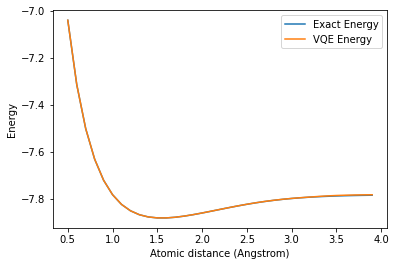

In [16]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.

## Observations about VQE
1. VQEs introduce us to an interesting paradigm: we create circuits with variable gates, which can potentially capture a target state given good values of the variables, and then delegate the solving process to a classical optimizer. This paradigm captures the essence of **Variational Quantum Algorithms**. 
2. VQAs are a natural extension to classical neural network models (see also [this review on VQAs](https://arxiv.org/abs/2012.09265) ), as is evident from the very similar approach employed for both. Just like classical neural network models, clever choices for the network and cost functions can generate excellent algorithms for solving many problems. In fact, as we will see later, they are so similar that we can easily embed quantum circuit layers into classical neural networks.

# Variational Quantum Algorithms

## Why VQA?
If they are so similar, why go for quantum, and why VQAs in general?
Provable gaurantees of efficiency of quantum over classical

In the following section we will go over one of the many applications for VQAs

## QAOA
The Quantum Approximate Optimisation Algorithm is one of most famous applications of VQAs. The algorithm is designed for combinatorial optimisation problems, in which we have to choose one of many possibilities. The max-cut problem, is one such combinatorial optimisation problem. Given an undirected flow graph, the objective is to partition the set of verticies in two, such that the sum of flows between the two partitions is maximised.

In [3]:
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.applications.ising import graph_partition
from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.applications.ising.common import random_graph, sample_most_likely

We will be working with the very simple flow graph as shown below. ( This graph has been taken from the great QAOA tutorial at this [blog](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained) )

In [4]:
num_nodes = 3
w = np.array([[0, 10, 10], [10, 0, 1], [10, 1, 0]])
print(w)

[[ 0 10 10]
 [10  0  1]
 [10  1  0]]


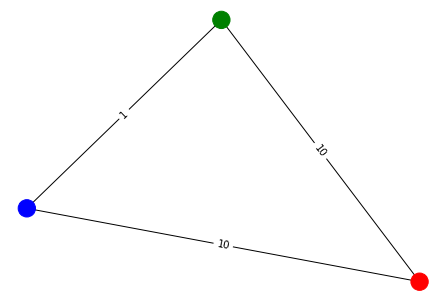

In [5]:
G = nx.from_numpy_matrix(w)
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

You will find that the process followed for VQAs is very similar to the VQE procedure

## Step 1: Obtaining the Operator
We model the max-cut problem as a cost maximisation problem. To do so, we model each vertex in the graph as a single qubit. The qubit being in state $\left|0\right\rangle$ or $\left|1\right\rangle$ represents whether the corresponding vertex is in the first or the second partition.

We devise the following cost hamiltonian. 

\begin{equation*}
H_C = \sum_{i,j} \frac{w_{i,j}}{2} (1 - \sigma_z^i\sigma_z^j)
\end{equation*}

Every state in which each qubit is either in either $\left|0\right\rangle$ or $\left|1\right\rangle$ is an eigenstate of this hamiltonian. The product $\sigma_z^i\sigma_z^j$ is 1 or -1 depending on whether vertices $i$ and $j$ are in the same or in different partitions. Thus the eigenvalue corresponding to any such state is equal to the sum of weights of edges going between the partitions. This is the exact value that we want to maximise in max-cut and hence we are satisfied with this construction of ours.

In [5]:
def brute_force():
    # use the brute-force way to generate the oracle
    def bitfield(n, L):
        result = np.binary_repr(n, L)
        return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

    L = num_nodes
    max = 2**L
    maximal_v = -np.inf
    for i in range(max):
        cur = bitfield(i, L)
        cur_v = 0
        
        for j in range(num_nodes):
            for k in range(num_nodes):
                if cur[j]!=cur[k]:
                    cur_v += w[j][k]
        
        cur_v/=2
        print(cur)
        print(cur_v)
        if cur_v > maximal_v:
            maximal_v = cur_v
    return maximal_v

sol = brute_force()
print(f'Objective value computed by the brute-force method is {sol}')

[0, 0, 0]
0.0
[0, 0, 1]
11.0
[0, 1, 0]
11.0
[0, 1, 1]
20.0
[1, 0, 0]
20.0
[1, 0, 1]
11.0
[1, 1, 0]
11.0
[1, 1, 1]
0.0
Objective value computed by the brute-force method is 20.0


## Step 2: Defining the ansatz
We use the following ansatz. It is developed by taking inspiration from adiabatic computation and trotterization, but is beyond the scope of this talk. Note that we take p as a parameter, which dictates the number of layers in our circuit. The higher the p the better results we get.

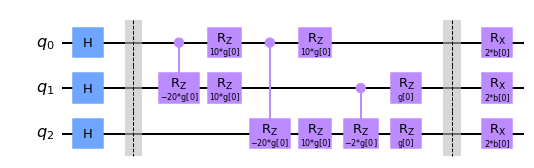

In [7]:
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector

def get_qaoa_ansatz(p=1, show=False):

    ansatz = QuantumCircuit(num_nodes)
    gamma = ParameterVector('g',p)
    beta = ParameterVector('b',p)
    
    for i in range(num_nodes):
        ansatz.h(i)

    for layer in range(p):
        if show:
            ansatz.barrier()

        for i in range(num_nodes):
            for j in range(i+1, num_nodes):
                ansatz.crz(-w[i][j]*2*gamma[layer], i, j)
                ansatz.rz(gamma[layer]*w[i][j], i)
                ansatz.rz(gamma[layer]*w[i][j], j)

        if show:
            ansatz.barrier()

        for i in range(num_nodes):
            ansatz.rx(beta[layer]*2,i)

#         ansatz.barrier()

        # ansatz.measure(range(num_nodes), range(num_nodes))

#     ansatz.draw()
    
    return ansatz

get_qaoa_ansatz(1, True).draw()

## Step 3: Optimising the parameters
Note the use of VQE routine of qiskit, to illustrate the similarity

In [9]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA
from IPython.display import display, clear_output
from qiskit.algorithms.optimizers import COBYLA
# provider = IBMQ.load_account()

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    
    
def run_qaoa(layers, backend_name):
    if backend_name != "statevector_simulator":
        backend = provider.get_backend(backend_name)
    else:
        backend = Aer.get_backend(backend_name)

    ansatz = get_qaoa_ansatz(layers)

    # Set initial parameters of the ansatz
    # We choose a fixed small displacement
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    from qiskit_optimization import QuadraticProgram
    from qiskit_optimization.algorithms import MinimumEigenOptimizer
    problem = QuadraticProgram()
    _ = [problem.binary_var('x{}'.format(i)) for i in range(num_nodes)]  # create n binary variables
    linear = w.dot(np.ones(num_nodes))
    quadratic = -w
    problem.maximize(linear=linear, quadratic=quadratic)

    from qiskit.aqua.operators import PauliExpectation
    # qaoa = QAOA(optimizer = COBYLA(maxiter=5000), 
    #             reps=layers, 
    #             quantum_instance=backend, 
    #             callback = callback, 
    #             initial_point = initial_point)
    qaoa = VQE(ansatz, optimizer=COBYLA(maxiter=10), quantum_instance=backend, callback = callback, initial_point= initial_point)
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(problem)
    return result, counts, values


counts = []
values = []  
result, counts, values = run_qaoa(1,"statevector_simulator")
print(result)

optimal function value: 20.0
optimal value: [1. 0. 0.]
status: SUCCESS


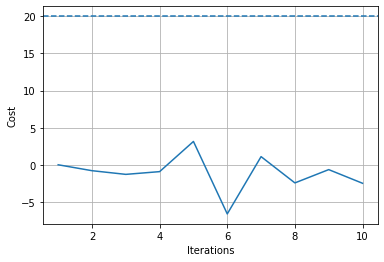

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.grid()
ax.plot(counts, values)
ax.axhline(20, linestyle='--')

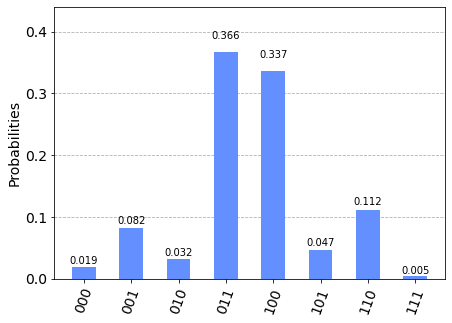

In [11]:
from qiskit.visualization import plot_histogram

hist={}
labels=[]

for entry in result.raw_samples:
#     hist.append({"".join([str(dig) for dig in entry.x]): entry.probability*1024})
    hist["".join([str(dig) for dig in entry.x])]= entry.probability*1024
    
plot_histogram(hist)

We get 70% probability of the best states, in just 10 steps!

# NISQ
Let's run the previous algorithm on real IBM hardware. We optimise for 10 steps to restrict the number of calls made to the hardware.

In [ ]:
counts = []
values = []  
result, counts, values = run_qaoa(1,"ibmq_belem")
print(result)

/opt/conda/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)


In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.grid()
ax.plot(counts, values)
ax.axhline(20, linestyle='--')

In [ ]:
hist={}
labels=[]

for entry in result.raw_samples:
#     hist.append({"".join([str(dig) for dig in entry.x]): entry.probability*1024})
    hist["".join([str(dig) for dig in entry.x])]= entry.probability*1024
    
plot_histogram(hist)

The hardware reports the following frequency of occurence of states out of 1024, after 10 optimisation steps.

<img src="bar-chart.png" />

Note that the probability of the best states are only slightly more than 25%, compared to 70% from the simulator. Besides, we could have got 25% from the uniform distribution itself. But, we only optimised for 10 steps and results are not totally dissapointing. The worst states have a significantly smaller probability than the uniform distribution.

# Hybrid NN for MNIST
Hybrid NN strive to overcome difficulties of using QNNs by running shallow circuits, and on very few qubits. They still potentially provide assurances similar to VQAs by interleaving quantum layers with classical layers.
In this example, derived from the qiskit textbook, we will append a quantum layer to a classical NN and attempt classification of 0 and 1 on the MNIST dataset. The purpose of this example is to illustrate the compatibility between quantum and classical neural networks and not to illustrate the advantages/disadvantages of any approach

<img src="neuralnetworkQC.png" />

### Code!

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

## 1. The quantum layer

In [12]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

## 2. Define forward and backward passes
Treat the quantum layer as a black box and compute gradients on the quantum layer using stochastic approximation

In [13]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

## 3. Creating the final NN

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

### Data Loading

In [15]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

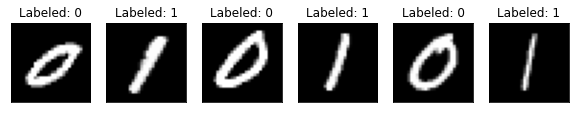

In [16]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [17]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

## 4. Training

In [18]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.7814
Training [10%]	Loss: -0.9142
Training [15%]	Loss: -0.9305
Training [20%]	Loss: -0.9376
Training [25%]	Loss: -0.9483
Training [30%]	Loss: -0.9558
Training [35%]	Loss: -0.9576
Training [40%]	Loss: -0.9570
Training [45%]	Loss: -0.9698
Training [50%]	Loss: -0.9646
Training [55%]	Loss: -0.9806
Training [60%]	Loss: -0.9727
Training [65%]	Loss: -0.9788
Training [70%]	Loss: -0.9855
Training [75%]	Loss: -0.9863
Training [80%]	Loss: -0.9840
Training [85%]	Loss: -0.9869
Training [90%]	Loss: -0.9862
Training [95%]	Loss: -0.9843
Training [100%]	Loss: -0.9885


Text(0, 0.5, 'Neg Log Likelihood Loss')

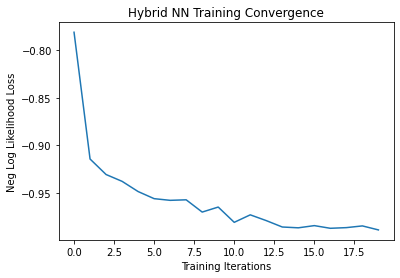

In [19]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

### Testing

In [20]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.9860
	Accuracy: 100.0%


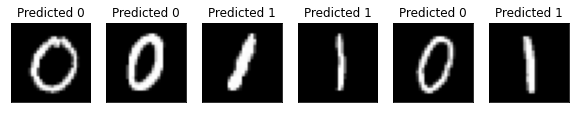

In [21]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

# Takeaways
1. Learnt VQE implementation and how they work
2. VQEs/VQAs have provable efficiencies gaurantees over classical techniques in many cases
3. Learnt QAOA implementation
4. VQAs are similar to classical NN and can be embedded into classical NNs
5. SOTA hardware work. But do introduce a lot of noise to the system. Need workarounds

# Questions